In [1]:
# keep track of time: see last cell for total time taken for this notebook to run
import time
start_time = time.time()

In [2]:
# to suppress warning from ete3 because it's not up to date with py3.12
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import ete3
import plotly.io as pio
import matplotlib as mpl
import seaborn as sns

# Set default renderer for Plotly
pio.renderers.default = 'notebook'

# seaborn colorblind palette
sns.set_palette("colorblind")

# serif font
mpl.rcParams["font.family"] = "serif"
scale_factor = 2
for key in mpl.rcParams:
    try:
        if "size" in key and isinstance(mpl.rcParams[key], (int, float)):
            mpl.rcParams[key] *= scale_factor
        elif "size" in key and isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                v * scale_factor if isinstance(v, (int, float)) else v
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key}: {e}")
        raise e

# Update legend rcParams
mpl.rcParams.update({
    "legend.facecolor": "white",
    "legend.frameon": True,
    "legend.edgecolor": "black",
})

# Define the maximum p-value for the statistical tests
alpha = 0.05

import importlib

# reload the library in case it has been updated
if "ags" in globals() and "ags" in locals():
    importlib.reload(ags)
from lib import analyse_genome_size as ags

# ignore FutureWarning for pandas
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# also ignore UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
warnings.filterwarnings("ignore", category=UserWarning, message="Attempt to set non-positive ylim on a log-scaled axis will be ignored.")

In [4]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
filtered_dir = os.path.join(data_dir, 'filtered')
compiled_results_dir = os.path.join(data_dir, 'compiled_results')

plots_dir = os.path.join(data_dir, 'plots', 'single_copy')
os.makedirs(plots_dir, exist_ok=True)

stats_dir = os.path.join(data_dir, 'stats', 'single_copy')
os.makedirs(stats_dir, exist_ok=True)

genome_tree_labeled_filepath = os.path.join(
    data_dir, 'genome_tree/genome_tree.iqtree.treefile.rooted.labeled'
)


In [5]:
# read in branch lengths from genome tree
genome_tree_filepath = os.path.join(
    data_dir, "genome_tree", "genome_tree.iqtree.treefile.rooted.labeled"
)
genome_tree = ete3.Tree(genome_tree_filepath, format=1)
branch_lengths = {n.name: n.dist for n in genome_tree.traverse()}

In [6]:
# read in genome sizes of all branches
genome_sizes_filepath = os.path.join(
    data_dir, "inferences", "gene_dynamics", "Count", "Count_genome_sizes.tsv"
)
genome_sizes_df = pd.read_csv(genome_sizes_filepath, sep="\t").rename(
    columns={"node": "branch"}
)
# drop the # PRESENT column
genome_sizes_df = genome_sizes_df.drop(columns=["# PRESENT"])

In [7]:
# Read ecotype count file and add missing branches
ecotype_count_df = pd.read_csv(
    os.path.join(compiled_results_dir, "compiled_dynamics.branchwise.ecotype.count.tsv"), sep="\t"
)
branch_names = [n.name for n in genome_tree.traverse()]
missing_branches_df = pd.DataFrame(
    {"branch": list(set(branch_names) - set(ecotype_count_df["branch"])), 
     "transfers": 0, "losses": 0, "expansions": 0, "reductions": 0}
)
ecotype_count_df = pd.concat([ecotype_count_df, missing_branches_df], ignore_index=True)
ecotype_count_df["branch_type"] = ecotype_count_df["transfers"].apply(
    lambda x: "EG" if x > 0 else "NEG"
)
ecotype_count_df = ecotype_count_df.merge(genome_sizes_df, on="branch")


## Do branches (including ancestral genomes) with and without ecosystem gains differ in the number of genes they have?

## How do gene gain/loss rates relate to the number of genes in a branch?

In [8]:
# varwise_branchwise_gene_dynamics_dfs_dict = {
#     os.path.basename(f).split("varwise.branchwise.gene.")[1].split(".tsv")[0]: 
#     pd.read_csv(f, header=0, sep="\t")
#     for f in [
#         f"{compiled_results_dir}/{fi}" for fi in os.listdir(compiled_results_dir)
#         if fi.startswith("compiled_dynamics.varwise.branchwise.gene.")
#     ]
# }
varwise_branchwise_gene_dynamics_dfs_dict = {"count": pd.read_csv(f"{compiled_results_dir}/compiled_dynamics.varwise.branchwise.gene.count.tsv", sep="\t")}


In [9]:
# read in the list of single copy NOGs
single_copy_nogs_list_filepath = os.path.join(
    filtered_dir, "map.nog_members_single_copy.tsv"
)
single_copy_nogs_list = pd.read_csv(
    single_copy_nogs_list_filepath, sep="\t", header=None, usecols=[0]
).squeeze().tolist()

In [10]:
# prepare branchwise gene dynamics dfs dict using the varwise_branchwise dict and the single_copy_nogs_list
gene_dynamics_dfs_dict = ags.extract_branchwise_subset_dfs(
    varwise_branchwise_gene_dynamics_dfs_dict, 
    subset_var_list=single_copy_nogs_list,
    var_name="nog_id",
    compiled_res_dir=compiled_results_dir,
    subset_name="sc",
)
# merge with genome sizes df
for method, df in gene_dynamics_dfs_dict.items():
    gene_dynamics_dfs_dict[method] = df.merge(
        genome_sizes_df, on="branch", how="left"
    )


In [11]:
gene_dynamics_dfs_dict["count"]

,branch,transfers,losses,expansions,reductions,genes,families,single-member families
0,104087,33,30,0,0,5341,2651,1795
1,105219,7,104,0,0,4069,2091,1429
2,106654,25,13,0,0,3505,2040,1480
3,109790,1,27,0,0,1411,988,781
4,1221500,9,179,0,0,3784,2143,1487
...,...,...,...,...,...,...,...,...
311,N95,26,49,0,0,4468,2277,1535
312,N96,107,139,0,0,7123,3434,2147
313,N97,55,114,0,0,6542,3248,2063
314,N98,24,210,0,0,4131,2305,1580


count, gain_rate: log(y) = 2.79 + 6.61e-04 * x 
 (Pearson r = 0.47, p-value = 1.04e-16)

count, gain_rate:



,branch,transfers,losses,expansions,reductions,genes,families,single-member families,branch_length,branch_type,gain_rate,loss_rate
173,N128,0,126,0,0,4911,2570,1779,0.130557,EG,0.000000,965.095705
66,246432,0,22,0,0,2565,1673,1244,0.177807,EG,0.000000,123.729662
64,238,0,490,0,0,2840,1527,1062,1.837730,EG,0.000000,266.633292
75,28903,0,336,0,0,613,439,365,2.530310,EG,0.000000,132.790053
57,195,0,534,0,0,1720,1252,984,1.996230,EG,0.000000,267.504246
...,...,...,...,...,...,...,...,...,...,...,...,...
209,N188,37,34,0,0,6508,3293,2129,0.089800,EG,412.027185,378.619575
195,N162,30,13,0,0,4008,2272,1608,0.064886,EG,462.348639,200.351077
192,N157,36,46,0,0,4917,2796,1942,0.038263,EG,940.861620,1202.212070
299,N72,81,17,0,0,5897,2944,1855,0.077053,EG,1051.227210,220.627933


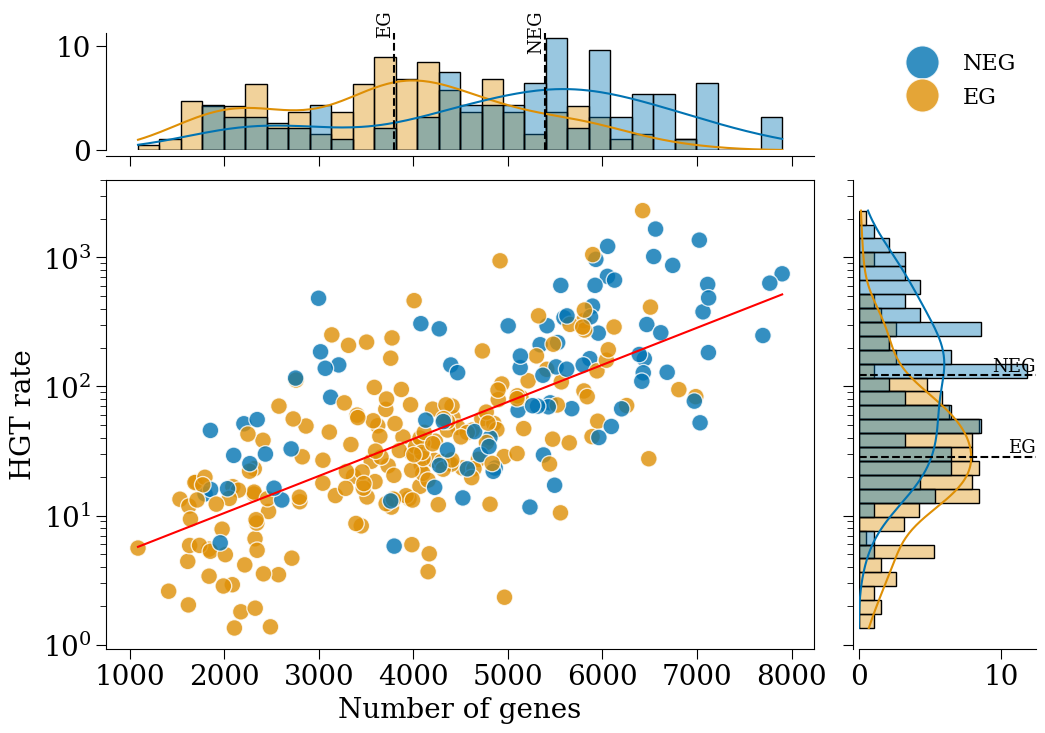

In [12]:

# loop through each method
rates_n_stats_all_dict = {}
for meth, compiled_gene_dynamics_df in gene_dynamics_dfs_dict.items():

    # call the function
    rates_n_stats_meth_dict = ags.analyze_genome_size_vs_hgt(
        meth=meth,
        compiled_gene_dynamics_df=compiled_gene_dynamics_df,
        branch_lengths_dict=branch_lengths,
        ecotype_count_df=ecotype_count_df,
        plots_dir=plots_dir,
        genome_size_col="genes",
        env="ecotype",
    )
    rates_n_stats_all_dict[meth] = rates_n_stats_meth_dict



## Modeling gene gain/loss rates as a function of the number of genes in a branch and whether there was an ecosystem gain or not

Model: `log(gene_gain_rate) ~ num_genes + ecosystem_gain(0/1) + intercept`
Note that we already know that the gene gain rate is exponentially related to the number of genes in a branch, so we are interested in the effect of ecosystem gain on the gene gain rate

In [13]:
# Initialize a list to store results
ols_results = []

# Add branch length and gain rate to each dataframe
for method in gene_dynamics_dfs_dict:
    gene_dynamics_dfs_dict[method]["branch_length"] = gene_dynamics_dfs_dict[method]["branch"].map(branch_lengths)
    gene_dynamics_dfs_dict[method]["gain_rate"] = gene_dynamics_dfs_dict[method]["transfers"] / gene_dynamics_dfs_dict[method]["branch_length"]
    gene_dynamics_dfs_dict[method]["loss_rate"] = gene_dynamics_dfs_dict[method]["losses"] / gene_dynamics_dfs_dict[method]["branch_length"]
    # Add branch type
    gene_dynamics_dfs_dict[method]["branch_type"] = gene_dynamics_dfs_dict[method]["branch"].map(
        lambda x: "EG" if x in ecotype_count_df.query("branch_type == 'EG'")["branch"].values else "NEG"
    )
    # Add genome size
    # gene_dynamics_dfs_dict[method] = gene_dynamics_dfs_dict[method].merge(genome_sizes_df, on="branch")
    # Add ecosystem gains
    gene_dynamics_dfs_dict[method]["ecosystem_gains"] = gene_dynamics_dfs_dict[method]["branch"].map(
        ecotype_count_df.set_index("branch")["branch_type"]
    ).eq("EG").astype(int)
# Loop through each method in the gene_dynamics_dfs_dict dictionary
for method, df in gene_dynamics_dfs_dict.items():
    df = df.query("gain_rate > 0").assign(
        log_gain_rate=np.log(df["gain_rate"])
    )

    # Fit OLS model
    results = smf.ols("log_gain_rate ~ genes + ecosystem_gains", data=df).fit()
    if method == "count":
        print(f"For method Count, the OLS results are:\n{results.summary()}")

    # Append results to the list
    ols_results.append({
        "method": method,
        **results.params.to_dict(),
        **{f"{k}_p": v for k, v in results.pvalues.items()}
    })

# Convert the results into a DataFrame
ols_results_df = pd.DataFrame(ols_results).set_index("method")
# sort columns
sorted_cols = sorted(ols_results_df.columns.tolist())
ols_results_df = ols_results_df[sorted_cols]
print("OLS results summary across all methods:")
display(ols_results_df)


For method Count, the OLS results are:
                            OLS Regression Results                            
Dep. Variable:          log_gain_rate   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     141.9
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           3.02e-43
Time:                        10:59:32   Log-Likelihood:                -404.32
No. Observations:                 282   AIC:                             814.6
Df Residuals:                     279   BIC:                             825.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Int

/root/mambaforge/envs/hgt_analyses/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log



,Intercept,Intercept_p,ecosystem_gains,ecosystem_gains_p,genes,genes_p
method,,,,,,
count,1.624904,7.252268e-11,-0.524241,0.000187,0.000602,5.473817e-34


In [14]:
# two models: one with ecosystem_gains as a variable, and one without
# compare the two models using ANOVA as well as LRT
# fit the two models
ols_results = {}
for method, df in gene_dynamics_dfs_dict.items():
    gain_rate_df = df[df["gain_rate"] > 0].copy()
    # Add log_gain_rate
    gain_rate_df["log_gain_rate"] = np.log(gain_rate_df["gain_rate"])
    gain_rate_df["ecosystem_gains"] = gain_rate_df["ecosystem_gains"].astype("category")
    # Fit OLS model with ecosystem_gains
    # model_with_eg = smf.ols("gain_rate ~ genes + ecosystem_gains", data=gain_rate_df).fit()
    # # Fit OLS model without ecosystem_gains
    # model_without_eg = smf.ols("gain_rate ~ genes", data=gain_rate_df).fit()

    # Fit GLM model with ecosystem_gains using Gamma family
    model_with_eg = smf.glm(
        "gain_rate ~ genes + ecosystem_gains",
        data=gain_rate_df,
        family=sm.families.Gaussian(
            link=sm.families.links.log()
        ),
    ).fit()
    # Fit GLM model without ecosystem_gains using Gamma family
    model_without_eg = smf.glm(
        "gain_rate ~ genes",
        data=gain_rate_df,
        family=sm.families.Gaussian(
            link=sm.families.links.log()
        ),
    ).fit()

    # if method is Count, print the summary of the model with ecosystem gains
    if method == "count":
        print(f"For method {method}, the model with ecosystem gains is:\n{model_with_eg.summary()}")
        print(f"For method {method}, the model without ecosystem gains is:\n{model_without_eg.summary()}")

    # Perform LRT
    lr_statistic = -2 * (model_without_eg.llf - model_with_eg.llf)  # reduced over full model
    p_value = st.chi2.sf(lr_statistic, 1)  # 1 degree of freedom

    # Store results
    ols_results[method] = {
        # "model_with_eg": model_with_eg,
        # "model_without_eg": model_without_eg,
        "lr_statistic": lr_statistic,
        "p_value": p_value,
    }
    # # Print the results
    # print(f"Method: {method}")
    # print("LRT results (with ecosystem gains minus without):")
    # print(f"LLR: {lr_statistic}, p-value: {p_value}")
    # print("\n" + "="*50 + "\n")

# Create a DataFrame to store the results
lrs_df = pd.DataFrame.from_dict(ols_results, orient="index")
# change method to replace all . with _
lrs_df.index = lrs_df.index.str.replace(".", " ").str.upper()
# rename columns
lrs_df = lrs_df.rename(
    columns={
        "lr_statistic": "LRT statistic",
        "p_value": "p-value",
    }
)
display(lrs_df)

For method count, the model with ecosystem gains is:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              gain_rate   No. Observations:                  282
Model:                            GLM   Df Residuals:                      279
Model Family:                Gaussian   Df Model:                            2
Link Function:                    log   Scale:                          48336.
Method:                          IRLS   Log-Likelihood:                -1919.5
Date:                Mon, 14 Jul 2025   Deviance:                   1.3486e+07
Time:                        10:59:32   Pearson chi2:                 1.35e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3104
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

,LRT statistic,p-value
COUNT,1.495796,0.221319


In [15]:
# combine all the stats records and display dfs
all_stats_dfs_dict = ags.combine_all_stats_records(rates_n_stats_all_dict)


Spearman correlation between rates and genome size:



,rate,method,branch_set,spearman_corr,p_value
0,gain_rate,count,all_branches,0.541421,1.828231e-25
1,gain_rate,count,branches_with_gains,0.686706,1.143807e-40



Linear regression coefficients for rates vs genome size:



,rate,method,a,b,num_branches
0,gain_rate,count,2.791969,0.000661,282



Spearman correlation for corrected rates vs genome size:



""



Count of branches with zero rates:



,rate,method,zero_rate_branch_count
0,gain_rate,count,34



Mann-Whitney U test results for rates between EG and NEG branches:



,rate,method,MWU statistic,p-value,EG Median,NEG Median,EG Mean,NEG Mean,Effect size (CLES),EG Size,NEG Size
0,gain_rate,count,7622.5,0.000003,28.529856,122.142694,72.632763,199.792183,0.339321,208,108



Mann-Whitney U test results for corrected rates between EG and NEG branches:



""



Mann-Whitney U test results for genome size between EG and NEG branches:



,rate,method,MWU statistic,p-value,EG Median,NEG Median,EG Mean,NEG Mean,Effect size (CLES)
0,gain_rate,count,5884.0,3.872968e-12,3800.0,5395.0,3750.875,5163.611111,0.26193


This seems to suggest that the gene gain rate is a function of the number of genes but not whether there was an ecosystem gain or not.

In [16]:
# calculate time taken in hh:mm:ss
print(
    f"Time taken to run the notebook: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}"
)

Time taken to run the notebook: 00:00:05
